In [ ]:
"""
CONTENT:
SECTION 1: Data Description
SECTION 2: Data Prepareation
SECTION 3: EDA
SECTION 4: Topic Modeling
SECTION 5: Word Cloud
SECTION 6: TF-IDF
"""

In [ ]:
"""
SECTION 1: Data Description
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
posts = pd.read_csv('Linkedin_Posts_Final.csv')

In [3]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29787 entries, 0 to 29786
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Post_ID         29787 non-null  int64 
 1   Post_Contents   29787 non-null  object
 2   User_ID         29787 non-null  int64 
 3   User_Name       29787 non-null  object
 4   User_Position   29207 non-null  object
 5   User_Company    29247 non-null  object
 6   Province        29247 non-null  object
 7   NAICS_Category  29444 non-null  object
 8   NAICS_Code      29444 non-null  object
 9   Year            29787 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.3+ MB


In [ ]:
"""
Key Feature:
1. Post_Contents: These are used to apply NPL analysis.
2. NAICS Category: This features itself can offer insight on areas that women have opportunities.
3. Year: This is used in time series analysis.
"""

In [ ]:
"""
SECTION 2: Data Preparation
For data preparation, we conver text to lowercase, remove punctuation, remove stopword, and turn words to root forms.
"""

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LdaMulticore

In [5]:
# Normalize text (convert to lowercase, remove punctuation)
posts['cleaned_content'] = posts['Post_Contents'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()

In [7]:
# stopword removal
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Remove stop words
posts.loc[:, 'cleaned_content'] = posts['cleaned_content'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#Lemmaization
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization with .loc to avoid SettingWithCopyWarning
posts.loc[:, 'cleaned_content'] = posts['cleaned_content'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
"""
SECTION 3: EDA
"""

In [ ]:
"""
SECTION 3.1: Demographic Analysis
"""

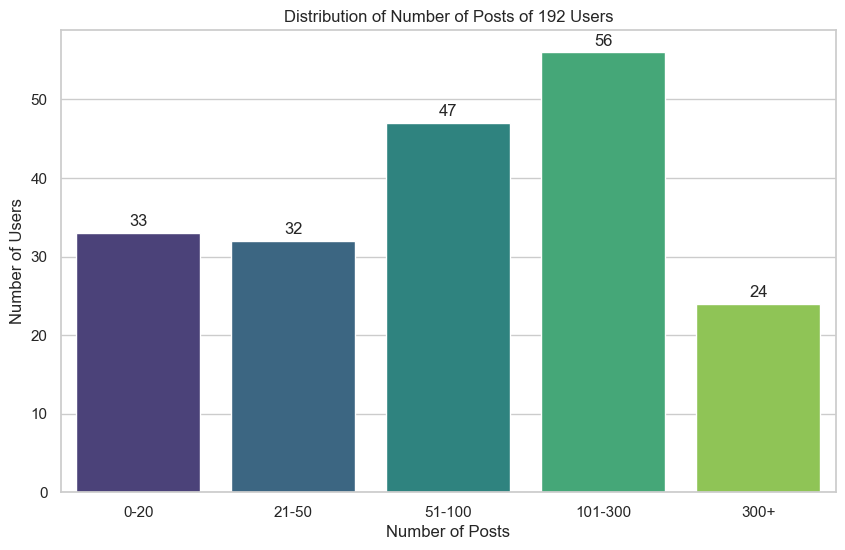

In [ ]:
# Explore Distribution of Number of Posts per User


sns.set(style="whitegrid")

# Group by 'User_ID' to get the number of posts per user
users = posts.groupby('User_ID').size().reset_index(name='post_count')

# Define custom bins
bins = [0, 20, 50, 100, 300, np.inf]
labels = ['0-20', '21-50', '51-100', '101-300', '300+']

# Create a new column categorizing users based on the bins
users['post_count_bins'] = pd.cut(users['post_count'], bins=bins, labels=labels, right=False)

# Plot the distribution using the custom bins
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    x='post_count_bins', data=users, palette='viridis', hue='post_count_bins', legend=False
)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",  # Convert height to integer
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position on the bar
        ha='center', va='center', xytext=(0, 8), textcoords='offset points'
    )
plt.title('Distribution of Number of Posts of 192 Users')
plt.xlabel('Number of Posts')
plt.ylabel('Number of Users')
plt.show()

In [ ]:
"""
The distribution above shows most users are moderately active, with fewer very active or minimally active users. Therefore, the textual data is not biased by some very active users.
"""

C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\1658319222.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=location_user_counts.index, y=location_user_counts.values, palette='viridis')


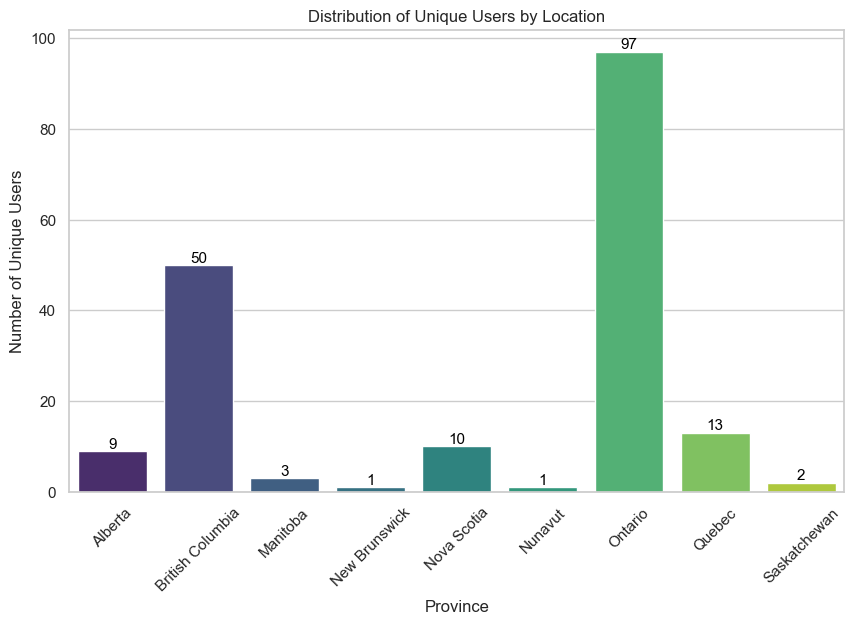

In [ ]:
# Distribution of Unique Users by Location

sns.set(style="whitegrid")

# Clean the 'Province' column by stripping extra spaces and standardizing to title case
posts['Province'] = posts['Province'].str.strip().str.title()

# Count the number of unique users per cleaned location
location_user_counts = posts.groupby('Province')['User_ID'].nunique()

# Create the barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=location_user_counts.index, y=location_user_counts.values, palette='viridis')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Add labels and title
plt.title('Distribution of Unique Users by Location')
plt.xlabel('Province')
plt.ylabel('Number of Unique Users')

# Rotate the x labels for readability
plt.xticks(rotation=45)

# Show plot
plt.show()

In [ ]:
"""
The distribution above suggests user activity is heavily concentrated in Ontario and British Columbia, with much lower representation in other provinces.
"""

C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\1571617580.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=user_count_by_industry.index, y=user_count_by_industry.values, palette='viridis')


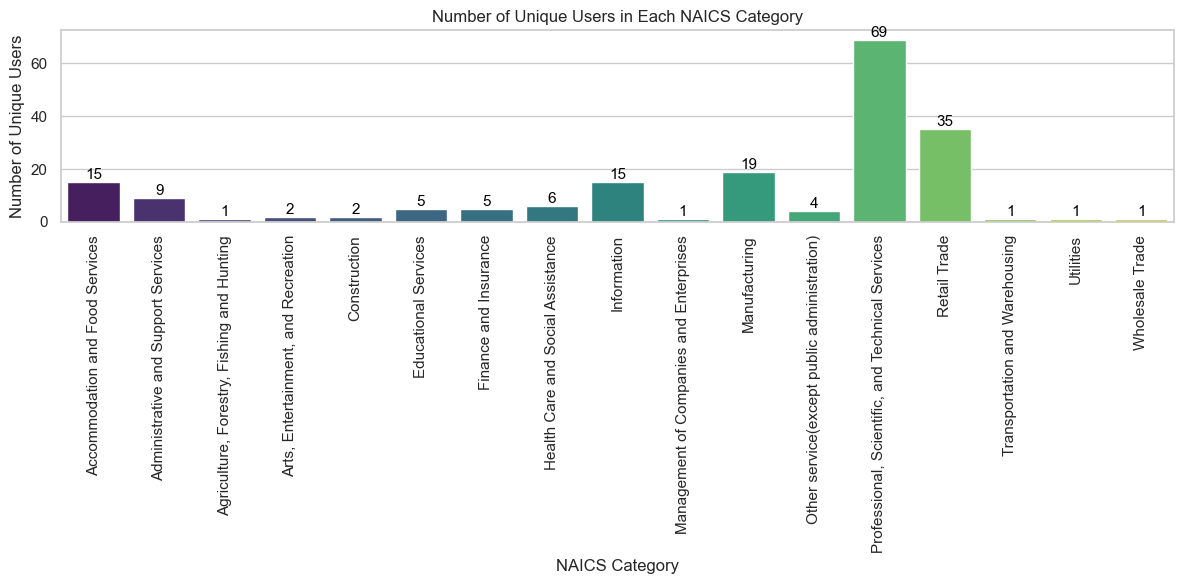

In [11]:
# Group the data to count unique users by NAICS category
user_count_by_industry = posts.groupby('NAICS_Category')['User_ID'].nunique()

# Create the barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=user_count_by_industry.index, y=user_count_by_industry.values, palette='viridis')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Add title and axis labels
plt.title('Number of Unique Users in Each NAICS Category')
plt.xlabel('NAICS Category')
plt.ylabel('Number of Unique Users')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
"""
The distribution above suggests the user base is heavily concentrated in professional services and retail sectors.
"""

In [ ]:
"""
SECTION 3.2: Posts Timeline Analysis
"""

In [ ]:
"""
1. posts are disproportionately distributed in recent years.
2. number of challenge related topics also increased in recent years.
3. proportion of challenge related posts increased in recent years.
"""

C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\1083308477.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


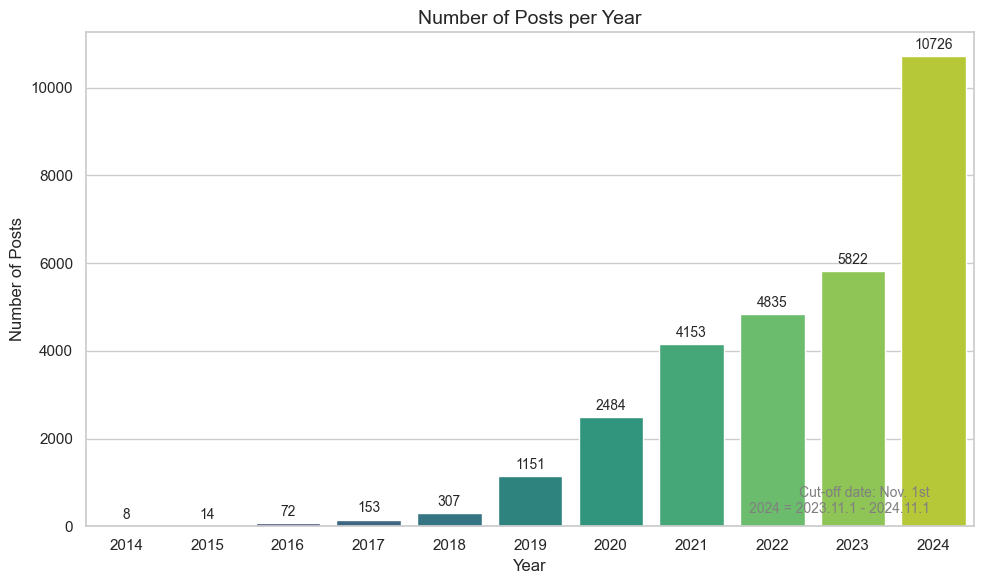

In [ ]:
challenge = pd.read_csv('semantic_challenge.csv')
df = pd.read_csv('Linkedin_Posts_Final.csv')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Year Transformed'] = 2024 - df['Year']

df_filtered = df.dropna(subset=['Year Transformed'])

# Count the occurrences of each year
year_counts = df_filtered['Year Transformed'].value_counts().sort_index()

# Create the plot
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(year_counts))

bar_plot = sns.barplot(
    x=year_counts.index,
    y=year_counts.values,
    palette=colors
)

# Add labels and title
plt.title('Number of Posts per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)

# Add numbers on top of each bar
for i, count in enumerate(year_counts.values):
    bar_plot.annotate(
        f"{count}",
        (i, count),
        ha='center', va='center',
        size=10, xytext=(0, 8),
        textcoords='offset points'
    )
plt.xticks(ticks=range(len(year_counts.index)), labels=year_counts.index.astype(int))
plt.text(
    x=0.95, y=0.02, s="Cut-off date: Nov. 1st\n2024 = 2023.11.1 - 2024.11.1", 
    fontsize=10, color='gray', ha='right', va='bottom', transform=plt.gca().transAxes
)
# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
"""
1. posts are disproportionately distributed in recent years.
reason: first, linkedin platform is more popular in recent years. second, only recent active users are recommended, biased our data.
"""

C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\468585788.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


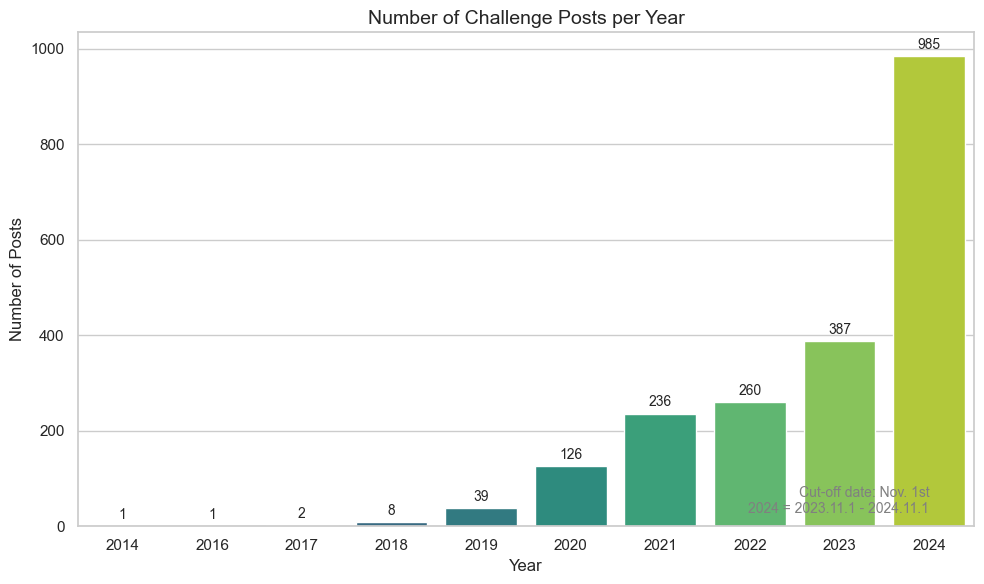

In [ ]:
# Transform the 'Year' column: 0 -> 2024, 1 -> 2023, etc.
challenge['Year'] = pd.to_numeric(challenge['Year'], errors='coerce')
challenge['Year Transformed'] = 2024 - challenge['Year']

# Filter out NaN values in the 'Year Transformed' column
challenge_filtered = challenge.dropna(subset=['Year Transformed'])

# Count the occurrences of each year
year_counts = challenge_filtered['Year Transformed'].value_counts().sort_index()

# Create the plot
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(year_counts))

bar_plot = sns.barplot(
    x=year_counts.index,
    y=year_counts.values,
    palette=colors
)

# Add labels and title
plt.title('Number of Challenge Posts per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)

# Add numbers on top of each bar
for i, count in enumerate(year_counts.values):
    bar_plot.annotate(
        f"{count}",
        (i, count),
        ha='center', va='center',
        size=10, xytext=(0, 8),
        textcoords='offset points'
    )
plt.xticks(ticks=range(len(year_counts.index)), labels=year_counts.index.astype(int))
plt.text(
    x=0.95, y=0.02, s="Cut-off date: Nov. 1st\n2024 = 2023.11.1 - 2024.11.1", 
    fontsize=10, color='gray', ha='right', va='bottom', transform=plt.gca().transAxes
)
# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
"""
2. number of challenge related topics also increased in recent years.
"""

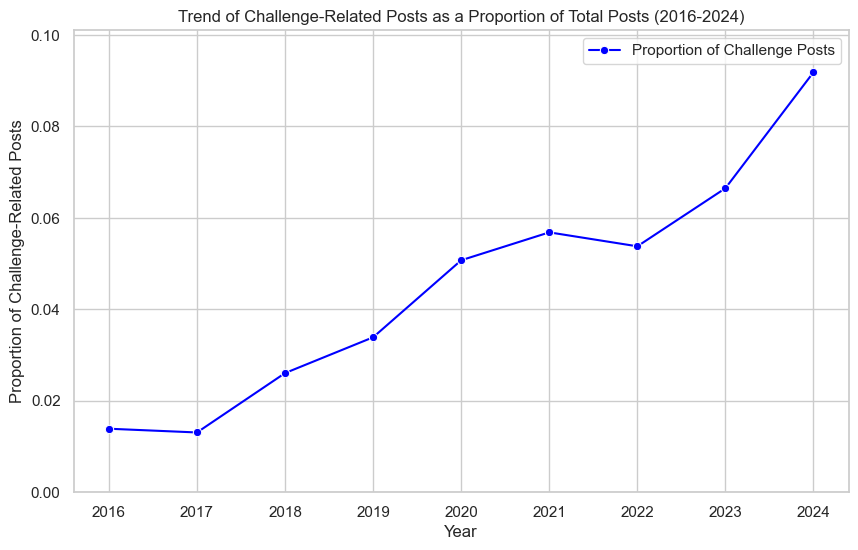

In [ ]:
years = np.arange(2016, 2025)  # Years from 2016 to 2024
num_challenge = [1, 2, 8, 39, 126, 236, 260, 387, 985]
num_posts = [72, 153, 307, 1151, 2484, 4153, 4835, 5822, 10726]
# Calculate the proportion of challenge-related posts
proportion_challenge = [c / p if p != 0 else 0 for c, p in zip(num_challenge, num_posts)]

# Create a line chart for the proportion
plt.figure(figsize=(10, 6))
sns.lineplot(x=years, y=proportion_challenge, marker='o', color='blue', label='Proportion of Challenge Posts')

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Proportion of Challenge-Related Posts")
plt.title("Trend of Challenge-Related Posts as a Proportion of Total Posts (2016-2024)")
plt.ylim(0, max(proportion_challenge) * 1.1)  # Add some padding to the y-axis
plt.legend()

# Show plot
plt.show()

In [ ]:
"""
3. proportion of challenge related posts increased in recent years.
reason: first, people may still struggling after covid. second, people in real challenge may be reluctant to share on Linkedin.
"""

In [ ]:
"""
SECTION 4: Topic Modeling
"""

In [ ]:
"""
SECTION 4.1: Create challeng and opportunity sub-dataframes
                using en_core_web_sm pretrained model, we can have results with keywords as well as semantic synonym.
                for challenge topic, we have 2083 posts.
                for opportunity topic, we have 3363 posts.
                """

In [14]:
import spacy
import re
import pandas as pd

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def is_challenge_related(text, threshold=0.5):
    # Check for keywords first
    keyword_match = bool(re.search(r'\b(challeng(e|ing|ed)?)\b', text, re.IGNORECASE))
    
    # If keyword match, return True immediately
    if keyword_match:
        return True
    
    # If no keyword, do semantic similarity
    try:
        # Process the text and 'challenge' with spaCy
        doc = nlp(str(text))
        challenge_doc = nlp('challenge')
        
        # Calculate semantic similarity
        similarity = doc.similarity(challenge_doc)
        
        return similarity >= threshold
    except:
        # Handle any processing errors
        return False

# Apply the function to your DataFrame
posts['is_challenge'] = posts['cleaned_content'].apply(is_challenge_related)

# Count challenge-related posts
challenge_count = posts['is_challenge'].sum()
print(f"Number of challenge-related posts: {challenge_count}")


c:\Users\rayma\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\1168822474.py:23: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
 

Number of challenge-related posts: 2083


In [15]:
# Load the English language model
nlp = spacy.load("en_core_web_sm")

def is_opportunity_related(text, threshold=0.5):
    # Keyword search for opportunity
    keyword_match = bool(re.search(r'\b(opportunit(y|ies))\b', text, re.IGNORECASE))
    
    # If keyword match, return True immediately
    if keyword_match:
        return True
    
    # If no keyword, do semantic similarity
    try:
        # Process the text with SpaCy
        doc = nlp(str(text))
        opportunity_doc = nlp('opportunity')
        
        # Calculate semantic similarity
        similarity = doc.similarity(opportunity_doc)
        
        return similarity >= threshold
    except:
        # Handle any processing errors
        return False

# Apply the function to your DataFrame
posts['is_opportunity'] = posts['cleaned_content'].apply(is_opportunity_related)

# Count opportunity-related posts
opportunity_count = posts['is_opportunity'].sum()
print(f"Number of opportunity-related posts: {opportunity_count}")

c:\Users\rayma\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\3743467758.py:19: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
 

Number of opportunity-related posts: 3363


In [ ]:
"""
SECTION 4.2: Challenge Topic Modeling
"""

In [ ]:
"""
1. first group topic in challenge related posts.
2. get a frequent keyword 'support'
3. group support related topics
4. interpret meaningful findings
"""

In [16]:
challenge_posts = posts[posts['is_challenge']]
# Create the document-term matrix for the 'challenge' posts
vectorizer = CountVectorizer(input='content', 
                             stop_words='english',
                             max_df=0.5, 
                             min_df=2)
X = vectorizer.fit_transform(challenge_posts['cleaned_content'])

# Create the dictionary and corpus for LDA
dictionary = corpora.Dictionary(challenge_posts['cleaned_content'].str.split())
corpus = [dictionary.doc2bow(text) for text in challenge_posts['cleaned_content'].str.split()]

# Train the LDA model on the 'challenge' posts
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=50)

# Print the topics related to 'challenge'
print("Topics containing 'challenge':")
for topic_id, topic in lda_model.print_topics(-1):
    if 'challenge' in topic:
        print(f"Topic {topic_id}: {topic}")

# Assign topic labels to each 'challenge' post
challenge_posts['topic'] = challenge_posts['cleaned_content'].apply(lambda text: lda_model[dictionary.doc2bow(text.split())][0][0])

# Explore the topic distributions for 'challenge' posts
topic_distribution = challenge_posts.groupby('topic').size().sort_values(ascending=False)
print("\nTopic Distribution for 'challenge' posts:")
print(topic_distribution)

Topics containing 'challenge':
Topic 0: 0.008*"challenge" + 0.004*"entrepreneur" + 0.004*"u" + 0.004*"support" + 0.004*"woman" + 0.004*"like" + 0.004*"founder" + 0.003*"change" + 0.003*"today" + 0.003*"community"
Topic 1: 0.019*"woman" + 0.009*"challenge" + 0.005*"global" + 0.004*"business" + 0.004*"entrepreneur" + 0.004*"world" + 0.004*"un" + 0.003*"leader" + 0.003*"africa" + 0.003*"founder"
Topic 2: 0.011*"challenge" + 0.004*"business" + 0.004*"marketing" + 0.004*"client" + 0.003*"founder" + 0.003*"one" + 0.003*"time" + 0.003*"community" + 0.003*"woman" + 0.003*"way"
Topic 3: 0.012*"woman" + 0.009*"business" + 0.009*"challenge" + 0.008*"global" + 0.005*"new" + 0.004*"time" + 0.004*"world" + 0.004*"entrepreneur" + 0.003*"un" + 0.003*"support"
Topic 4: 0.010*"business" + 0.008*"woman" + 0.007*"global" + 0.007*"challenge" + 0.005*"leader" + 0.005*"founder" + 0.004*"future" + 0.004*"groyourbiz" + 0.004*"work" + 0.003*"support"
Topic 5: 0.010*"woman" + 0.009*"challenge" + 0.009*"business"

C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\2924764500.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  challenge_posts['topic'] = challenge_posts['cleaned_content'].apply(lambda text: lda_model[dictionary.doc2bow(text.split())][0][0])


C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\1113889544.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Word', y='Count', data=data, palette='viridis')


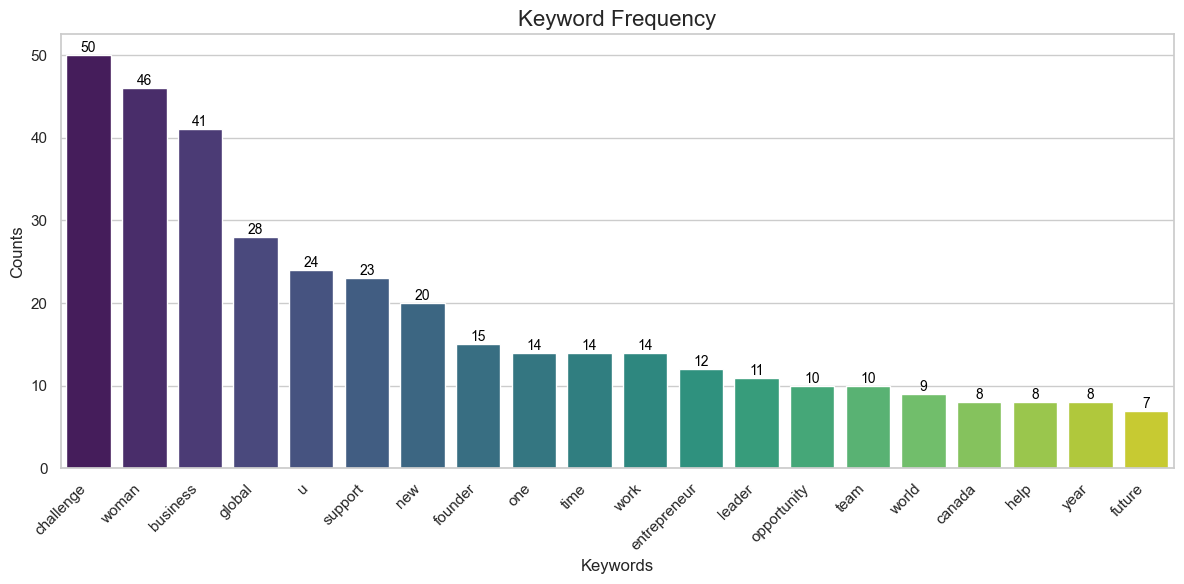

In [17]:
from collections import Counter

# Initialize a Counter object to store word frequencies
word_counter = Counter()

# Extract topics from the LDA model
for topic_id, topic in lda_model.print_topics(-1):
    # Split the topic string into words (ignoring weights and special characters)
    words = [word.split('*')[1].strip().strip('"') for word in topic.split('+')]
    # Update the word counter
    word_counter.update(words)

# Convert the Counter object into a sorted dictionary (descending by count)
sorted_word_count_dict = dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))
top_20_words = list(sorted_word_count_dict.items())[:20]
words, counts = zip(*top_20_words)  # Separate into words and counts

# Create a DataFrame for seaborn
data = pd.DataFrame({'Word': words, 'Count': counts})

# Set seaborn style
sns.set(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(12, 6))  # Set figure size
ax = sns.barplot(x='Word', y='Count', data=data, palette='viridis')

# Add titles and labels
plt.title('Keyword Frequency', fontsize=16)
plt.xlabel('Keywords', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

# Annotate the bars with the count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Show the chart
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [18]:
# Create the document-term matrix
vectorizer = CountVectorizer(input='content', 
                             stop_words='english',
                             max_df=0.5, 
                             min_df=2)
X = vectorizer.fit_transform(challenge_posts['cleaned_content'])

# Create the dictionary and corpus
dictionary = corpora.Dictionary(challenge_posts['cleaned_content'].str.split())
corpus = [dictionary.doc2bow(text) for text in challenge_posts['cleaned_content'].str.split()]

# Train the LDA model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=50)

# Print topics containing specific keywords
keywords_to_check = ['support']

print("Topics containing 'support':")
for topic_id, topic in lda_model.print_topics(-1):
    # Check if any of the keywords are in the topic
    if any(keyword in topic.lower() for keyword in keywords_to_check):
        print(f"Topic {topic_id}: {topic}")

# Assign topic labels to posts
challenge_posts['topic'] = challenge_posts['cleaned_content'].apply(lambda text: lda_model[dictionary.doc2bow(text.split())][0][0])

# Explore the topic distributions
topic_distribution = challenge_posts.groupby('topic').size().sort_values(ascending=False)
print("\nTopic Distribution:")
print(topic_distribution)

Topics containing 'support':
Topic 0: 0.016*"woman" + 0.012*"challenge" + 0.011*"business" + 0.007*"n" + 0.006*"global" + 0.004*"support" + 0.004*"entrepreneur" + 0.004*"today" + 0.004*"leader" + 0.003*"journey"
Topic 5: 0.008*"challenge" + 0.005*"woman" + 0.003*"one" + 0.003*"world" + 0.003*"support" + 0.003*"help" + 0.003*"community" + 0.003*"n" + 0.003*"also" + 0.003*"impact"
Topic 6: 0.012*"challenge" + 0.009*"woman" + 0.005*"business" + 0.005*"u" + 0.004*"one" + 0.003*"global" + 0.003*"support" + 0.003*"world" + 0.003*"journey" + 0.003*"new"
Topic 7: 0.012*"woman" + 0.009*"challenge" + 0.007*"global" + 0.006*"business" + 0.004*"leader" + 0.004*"support" + 0.004*"world" + 0.004*"opportunity" + 0.004*"founder" + 0.004*"team"
Topic 10: 0.015*"â" + 0.011*"woman" + 0.010*"challenge" + 0.007*"business" + 0.005*"un" + 0.005*"empower" + 0.004*"support" + 0.004*"founder" + 0.004*"world" + 0.004*"opportunity"
Topic 12: 0.007*"challenge" + 0.005*"n" + 0.005*"life" + 0.005*"support" + 0.004*"

C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\2605925876.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  challenge_posts['topic'] = challenge_posts['cleaned_content'].apply(lambda text: lda_model[dictionary.doc2bow(text.split())][0][0])


C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\2258847308.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Word', y='Count', data=df, palette='viridis')


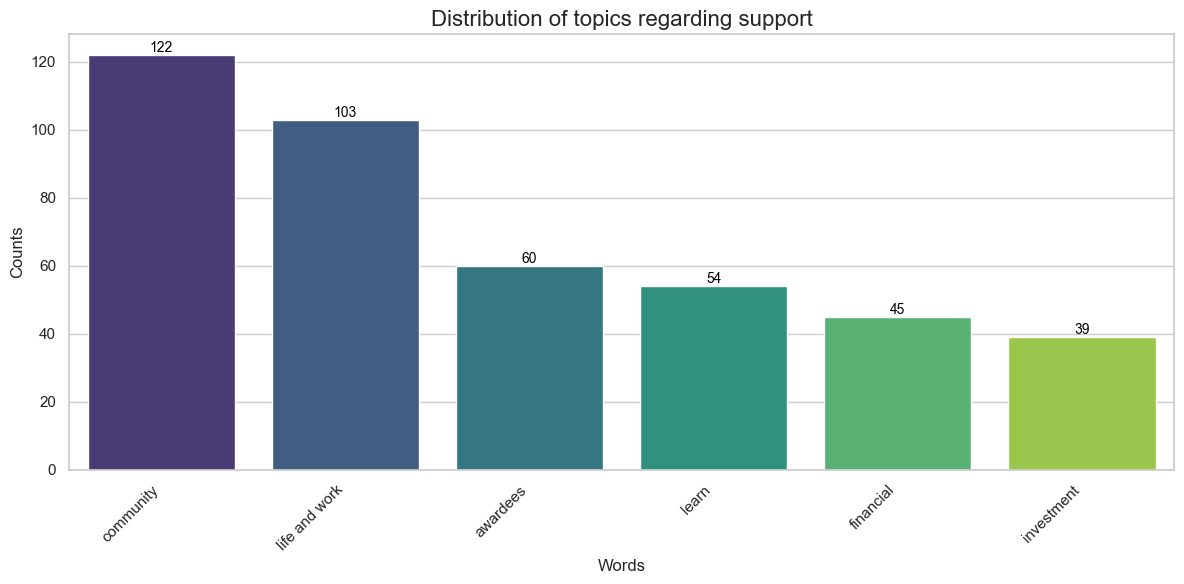

In [19]:
data = {
    'Word': ['community', 'life and work', 'awardees', 'learn', 'financial', 'investment'],
    'Count': [122, 103, 60, 54, 45, 39]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set seaborn style
sns.set(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(12, 6))  # Set figure size
ax = sns.barplot(x='Word', y='Count', data=df, palette='viridis')

# Add titles and labels
plt.title('Distribution of topics regarding support', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

# Annotate the bars with the integer count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Cast height to integer
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Show the chart
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [ ]:
"""
All above keywords provide insights for women enterpreneurs' challenges. 
They need community support, life and work balance support, third party recognition, learning opportunities, financial support, and investment.
"""

In [ ]:
"""
SECTION 4.3: Opportunity Topic Modeling
"""

In [ ]:
"""
There is no insightful finding regarding opportunity topic modeling.
"""

In [20]:
opportunity_posts = posts[posts['is_opportunity']]
# Create the document-term matrix for the 'opportunity' posts
vectorizer = CountVectorizer(input='content', 
                             stop_words='english',
                             max_df=0.5, 
                             min_df=2)
X = vectorizer.fit_transform(opportunity_posts['cleaned_content'])

# Create the dictionary and corpus for LDA
dictionary = corpora.Dictionary(opportunity_posts['cleaned_content'].str.split())
corpus = [dictionary.doc2bow(text) for text in opportunity_posts['cleaned_content'].str.split()]

# Train the LDA model on the 'opportunity' posts
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=50)

# Print the topics related to 'opportunity'
print("Topics containing 'opportunity':")
for topic_id, topic in lda_model.print_topics(-1):
    if 'opportunity' in topic:
        print(f"Topic {topic_id}: {topic}")

# Assign topic labels to each 'opportunity' post
opportunity_posts['topic'] = opportunity_posts['cleaned_content'].apply(lambda text: lda_model[dictionary.doc2bow(text.split())][0][0])

# Explore the topic distributions for 'opportunity' posts
topic_distribution = opportunity_posts.groupby('topic').size().sort_values(ascending=False)
print("\nTopic Distribution for 'opportunity' posts:")
print(topic_distribution)

Topics containing 'opportunity':
Topic 0: 0.012*"opportunity" + 0.007*"business" + 0.005*"u" + 0.005*"work" + 0.005*"share" + 0.004*"time" + 0.004*"life" + 0.004*"need" + 0.003*"experience" + 0.003*"brand"
Topic 1: 0.017*"opportunity" + 0.005*"woman" + 0.005*"new" + 0.004*"business" + 0.004*"u" + 0.004*"team" + 0.004*"canada" + 0.003*"international" + 0.003*"year" + 0.003*"great"
Topic 2: 0.013*"opportunity" + 0.011*"de" + 0.008*"woman" + 0.007*"canada" + 0.005*"business" + 0.005*"u" + 0.004*"ã" + 0.004*"entrepreneur" + 0.004*"work" + 0.003*"team"
Topic 3: 0.016*"opportunity" + 0.011*"business" + 0.008*"woman" + 0.007*"ãâ" + 0.006*"canada" + 0.005*"leader" + 0.005*"u" + 0.004*"year" + 0.004*"program" + 0.003*"new"
Topic 4: 0.017*"opportunity" + 0.006*"business" + 0.006*"woman" + 0.005*"program" + 0.004*"incredible" + 0.004*"support" + 0.004*"year" + 0.004*"work" + 0.004*"professional" + 0.003*"experience"
Topic 5: 0.018*"â" + 0.012*"opportunity" + 0.005*"event" + 0.005*"support" + 0.00

C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\3991950476.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opportunity_posts['topic'] = opportunity_posts['cleaned_content'].apply(lambda text: lda_model[dictionary.doc2bow(text.split())][0][0])


C:\Users\rayma\AppData\Local\Temp\ipykernel_21448\1113889544.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Word', y='Count', data=data, palette='viridis')


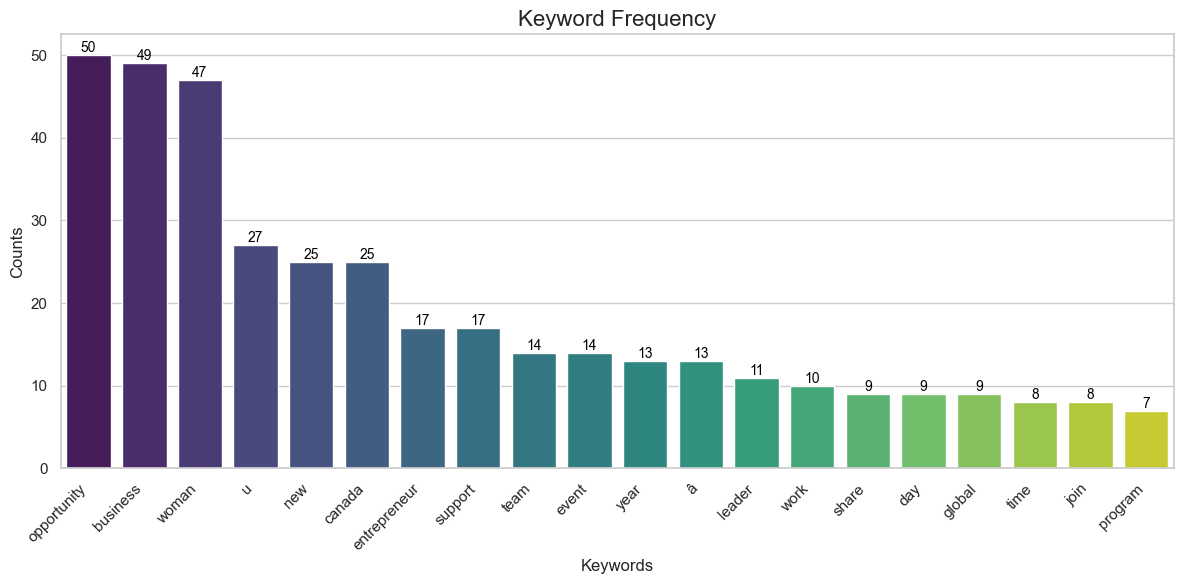

In [21]:
from collections import Counter

# Initialize a Counter object to store word frequencies
word_counter = Counter()

# Extract topics from the LDA model
for topic_id, topic in lda_model.print_topics(-1):
    # Split the topic string into words (ignoring weights and special characters)
    words = [word.split('*')[1].strip().strip('"') for word in topic.split('+')]
    # Update the word counter
    word_counter.update(words)

# Convert the Counter object into a sorted dictionary (descending by count)
sorted_word_count_dict = dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))
top_20_words = list(sorted_word_count_dict.items())[:20]
words, counts = zip(*top_20_words)  # Separate into words and counts

# Create a DataFrame for seaborn
data = pd.DataFrame({'Word': words, 'Count': counts})

# Set seaborn style
sns.set(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(12, 6))  # Set figure size
ax = sns.barplot(x='Word', y='Count', data=data, palette='viridis')

# Add titles and labels
plt.title('Keyword Frequency', fontsize=16)
plt.xlabel('Keywords', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

# Annotate the bars with the count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Show the chart
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [ ]:
"""
All results are too genral
"""

In [ ]:
"""
SECTION 5: Word Cloud Analysis
This part compares the word cloud before covid and during covid.
Results show that the word cloud during covid and before covid are not very different.
"""


Analysis for After COVID:
Total Posts: 21383
Unique Users: 185

Top 50 Most Frequent Words of challenge:
- our: 15624
- women: 7571
- more: 7043
- business: 6675
- all: 6095
- who: 5164
- canada: 4558
- its: 4430
- how: 4412
- what: 4288
- not: 4271
- out: 4257
- new: 4148
- support: 3680
- one: 3672
- team: 3537
- work: 3516
- time: 3378
- make: 2768
- day: 2719
- get: 2701
- just: 2677
- people: 2652
- when: 2596
- here: 2583
- community: 2571
- now: 2559
- world: 2527
- know: 2503
- help: 2486
- global: 2476
- incredible: 2424
- event: 2337
- many: 2280
- join: 2258
- first: 2252
- leaders: 2252
- years: 2234
- through: 2226
- entrepreneurs: 2197
- see: 2177
- year: 2168
- today: 2144
- great: 2140
- also: 2093
- thank: 2080
- amazing: 2080
- some: 2073
- learn: 2069
- health: 2049

Analysis for DURING COVID:
Total Posts: 6637
Unique Users: 127

Top 50 Most Frequent Words of challenge:
- our: 4013
- women: 1884
- more: 1720
- business: 1508
- all: 1414
- how: 1205
- who: 1180
- new

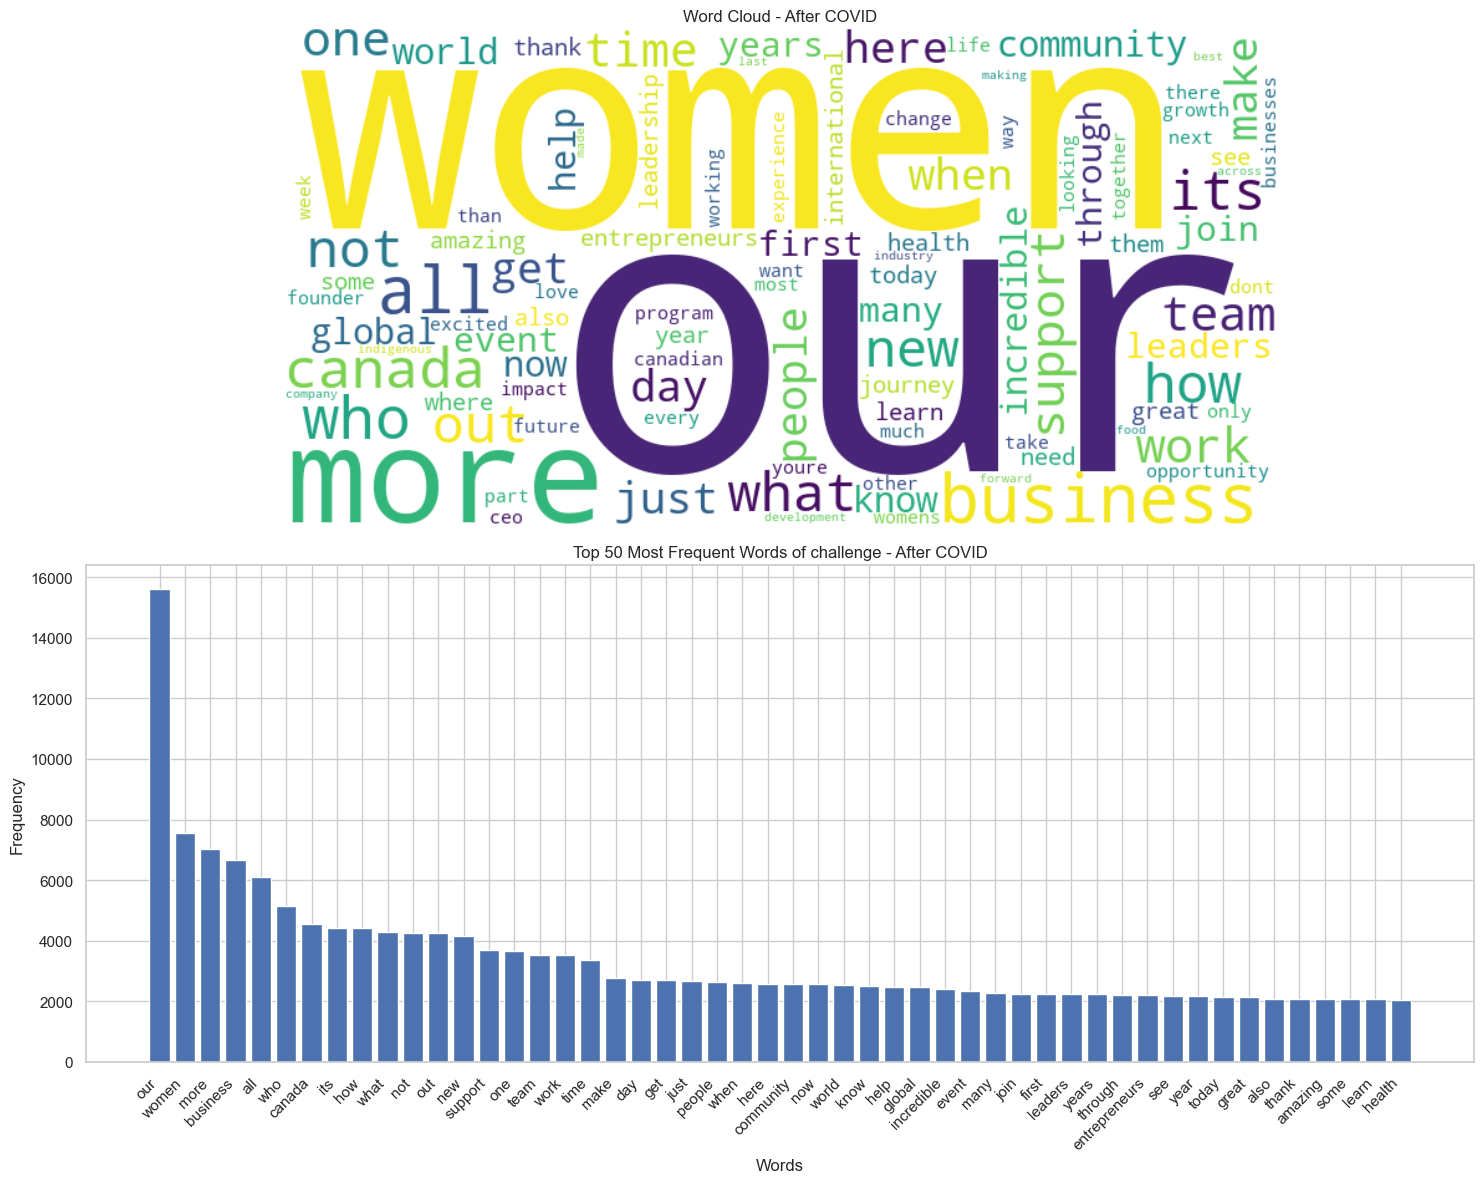

<Figure size 640x480 with 0 Axes>

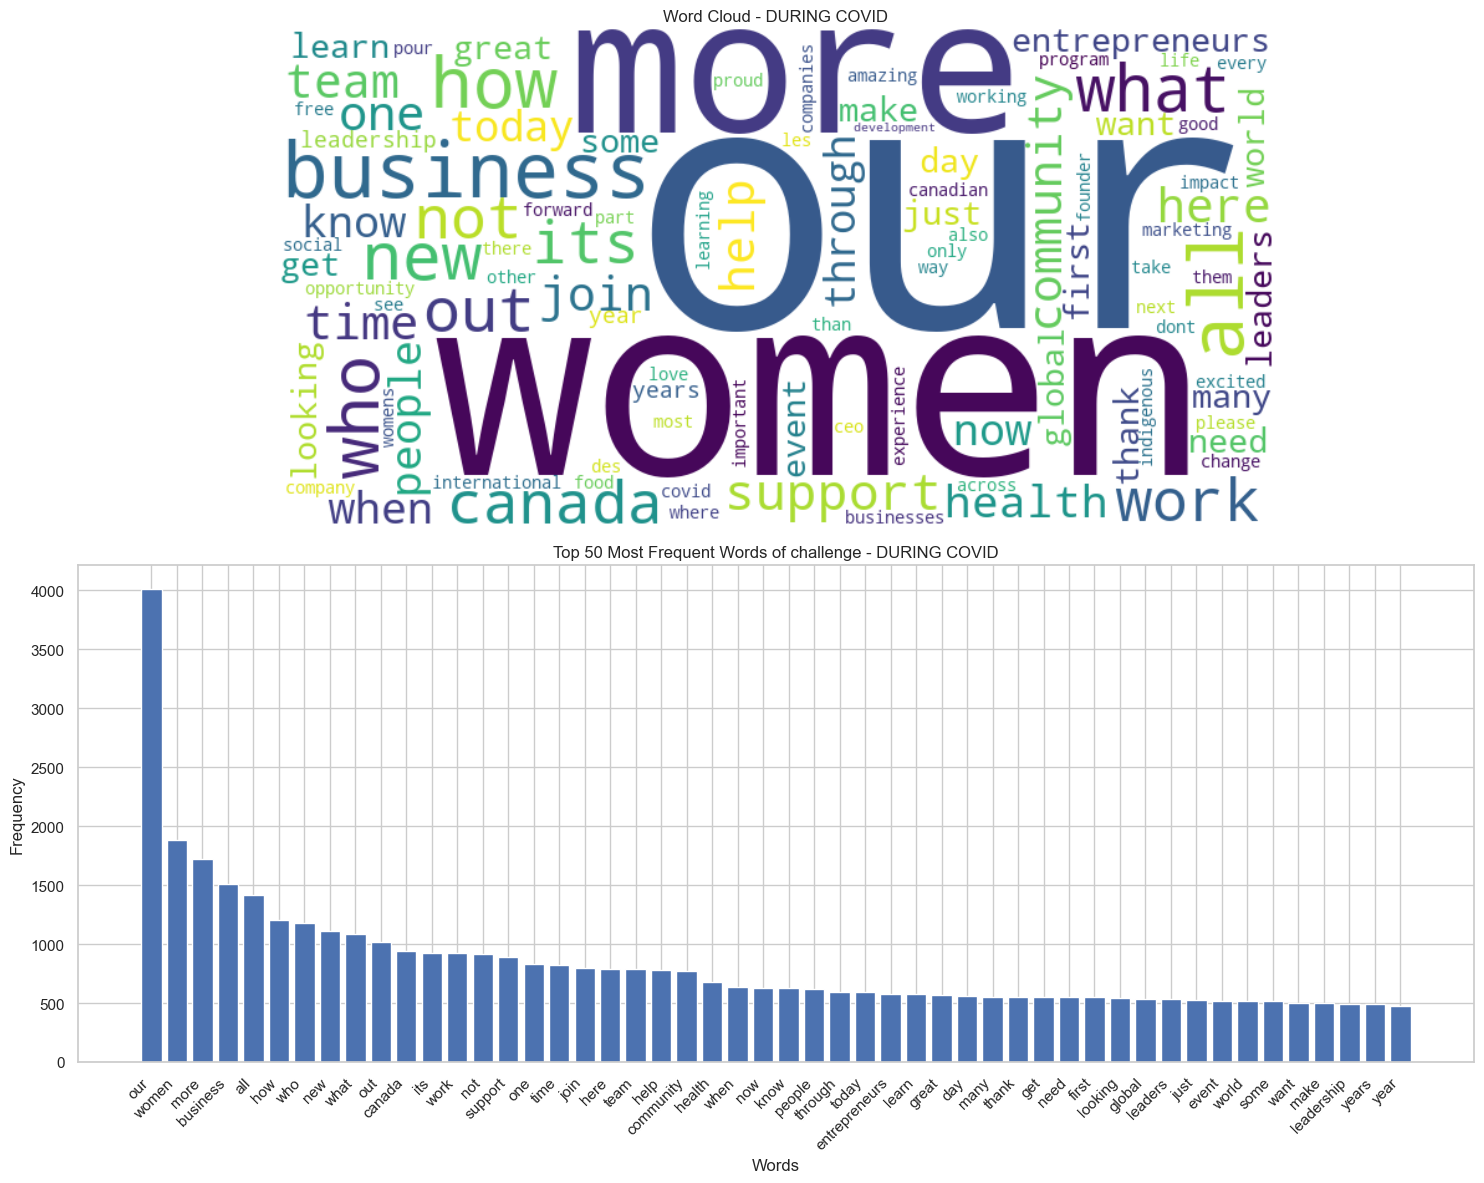

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import re

file_path = 'Linkedin_Posts_Final.csv'


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return ' '.join(text.split())


try:
    df = pd.read_csv(file_path, encoding='latin1')
    # Convert Year column to integer
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    stop_words = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'from', 'up', 'about', 'into', 'over', 'after',
        'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
        'do', 'does', 'did', 'will', 'would', 'shall', 'should', 'can', 'could',
        'may', 'might', 'must', 'i', 'you', 'he', 'she', 'it', 'we', 'they',
        'this', 'that', 'these', 'those', 'am', 'im', 'your', 'their', 'his', 'her',
        'like', 'comment', 'share', 'post', 'follow'
    }

    df_early = df[df['Year'].between(0, 2)]
    df_late = df[df['Year'].between(3, 4)]


    def analyze_text(dataframe, title):
        cleaned_posts = dataframe['Post_Contents'].apply(clean_text)
        combined_text = ' '.join(cleaned_posts)
        tokens = combined_text.split()
        filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        word_freq = Counter(filtered_tokens)
        top_words = dict(word_freq.most_common(50))

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        wordcloud = WordCloud(width=800, height=400,
                              background_color='white',
                              max_words=100).generate_from_frequencies(word_freq)
        ax1.imshow(wordcloud, interpolation='bilinear')
        ax1.axis('off')
        ax1.set_title(f'Word Cloud - {title}')

        ax2.bar(top_words.keys(), top_words.values())
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax2.set_title(f'Top 50 Most Frequent Words of challenge - {title}')
        ax2.set_xlabel('Words')
        ax2.set_ylabel('Frequency')

        plt.tight_layout()

        print(f"\nAnalysis for {title}:")
        print(f"Total Posts: {len(dataframe)}")
        print(f"Unique Users: {dataframe['User_ID'].nunique()}")
        print("\nTop 50 Most Frequent Words of challenge:")
        for word, count in top_words.items():
            print(f"- {word}: {count}")


    analyze_text(df_early, "After COVID")
    plt.figure()
    analyze_text(df_late, "DURING COVID")

    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback

    print(traceback.format_exc())

In [ ]:
"""
After COVID(2022-now), the key words didn’t change radically according to the results of the word cloud, still focus on women and business, however, we noticed the word Global merged on the list, which indicating there are more collaboration and traveling across countries for Canadian women entrepreneurs. 
"""


Analysis for After COVID:
Total Posts: 21383
Unique Users: 185

Top 50 Most Frequent Words of opportunity:
- our: 15624
- women: 7571
- more: 7043
- business: 6675
- all: 6095
- who: 5164
- canada: 4558
- its: 4430
- how: 4412
- what: 4288
- not: 4271
- out: 4257
- new: 4148
- support: 3680
- one: 3672
- team: 3537
- work: 3516
- time: 3378
- make: 2768
- day: 2719
- get: 2701
- just: 2677
- people: 2652
- when: 2596
- here: 2583
- community: 2571
- now: 2559
- world: 2527
- know: 2503
- help: 2486
- global: 2476
- incredible: 2424
- event: 2337
- many: 2280
- join: 2258
- first: 2252
- leaders: 2252
- years: 2234
- through: 2226
- entrepreneurs: 2197
- see: 2177
- year: 2168
- today: 2144
- great: 2140
- also: 2093
- thank: 2080
- amazing: 2080
- some: 2073
- learn: 2069
- health: 2049

Analysis for DURING COVID:
Total Posts: 6637
Unique Users: 127

Top 50 Most Frequent Words of opportunity:
- our: 4013
- women: 1884
- more: 1720
- business: 1508
- all: 1414
- how: 1205
- who: 1180
-

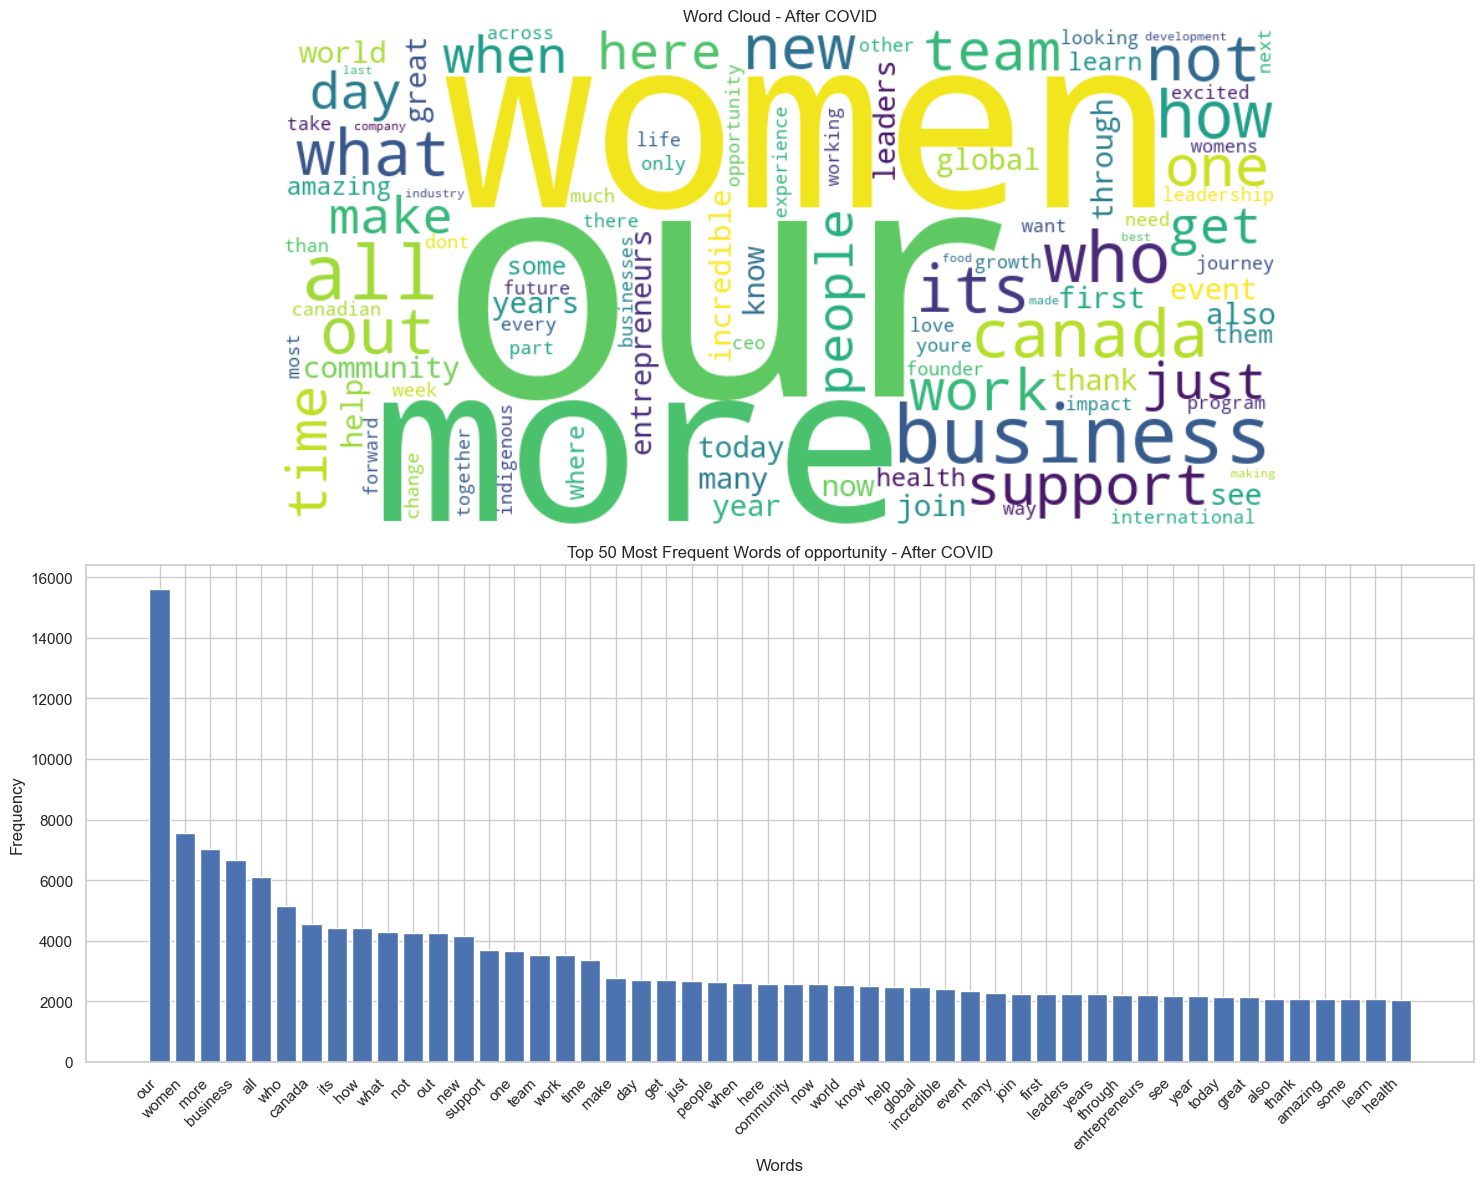

<Figure size 640x480 with 0 Axes>

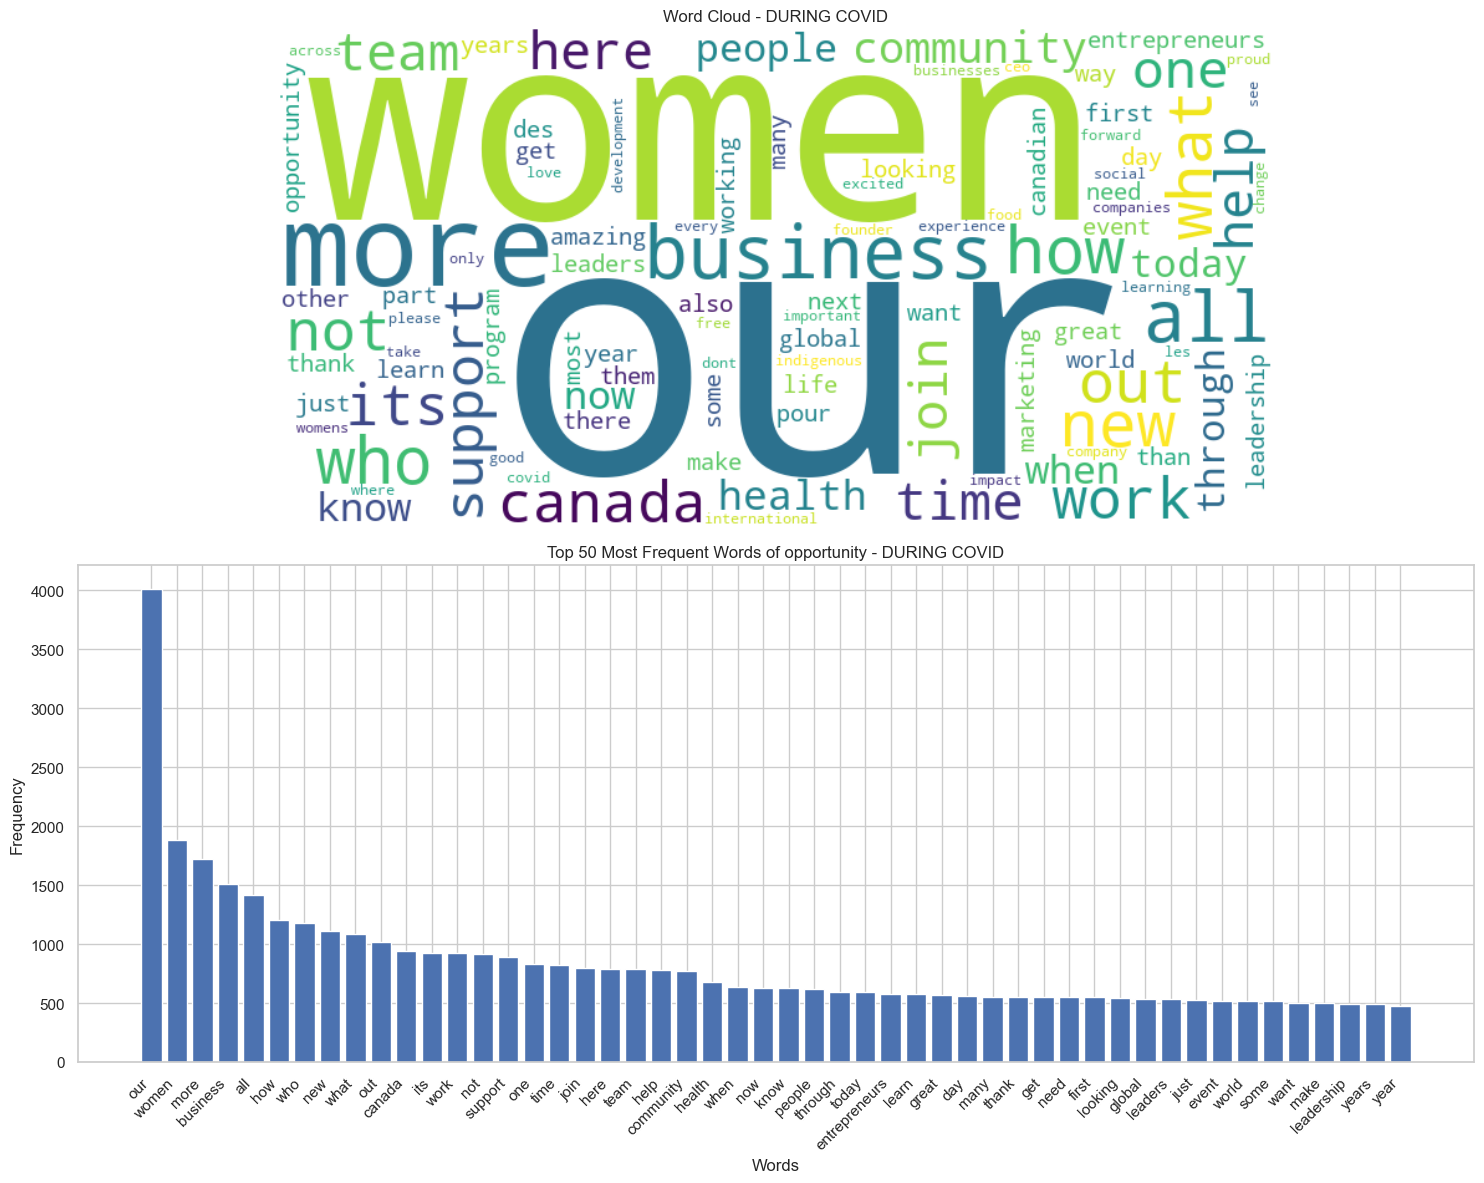

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return ' '.join(text.split())


try:
    df = pd.read_csv(file_path, encoding='latin1')
    # Convert Year column to integer
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    stop_words = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'from', 'up', 'about', 'into', 'over', 'after',
        'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
        'do', 'does', 'did', 'will', 'would', 'shall', 'should', 'can', 'could',
        'may', 'might', 'must', 'i', 'you', 'he', 'she', 'it', 'we', 'they',
        'this', 'that', 'these', 'those', 'am', 'im', 'your', 'their', 'his', 'her',
        'like', 'comment', 'share', 'post', 'follow'
    }

    df_early = df[df['Year'].between(0, 2)]
    df_late = df[df['Year'].between(3, 4)]


    def analyze_text(dataframe, title):
        cleaned_posts = dataframe['Post_Contents'].apply(clean_text)
        combined_text = ' '.join(cleaned_posts)
        tokens = combined_text.split()
        filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        word_freq = Counter(filtered_tokens)
        top_words = dict(word_freq.most_common(50))

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        wordcloud = WordCloud(width=800, height=400,
                              background_color='white',
                              max_words=100).generate_from_frequencies(word_freq)
        ax1.imshow(wordcloud, interpolation='bilinear')
        ax1.axis('off')
        ax1.set_title(f'Word Cloud - {title}')

        ax2.bar(top_words.keys(), top_words.values())
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax2.set_title(f'Top 50 Most Frequent Words of opportunity - {title}')
        ax2.set_xlabel('Words')
        ax2.set_ylabel('Frequency')

        plt.tight_layout()

        print(f"\nAnalysis for {title}:")
        print(f"Total Posts: {len(dataframe)}")
        print(f"Unique Users: {dataframe['User_ID'].nunique()}")
        print("\nTop 50 Most Frequent Words of opportunity:")
        for word, count in top_words.items():
            print(f"- {word}: {count}")


    analyze_text(df_early, "After COVID")
    plt.figure()
    analyze_text(df_late, "DURING COVID")

    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback

    print(traceback.format_exc())

In [ ]:
"""
After COVID, the most frequent words didn’t see a radical change, which is the same situation as ‘challenge’
"""

In [ ]:
"""
SECTION 6: TF-IDF Analysis
"""

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers, but keep letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Get stop words for English
    stop_words = set(stopwords.words('english'))
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join the tokens back into a string
    return ' '.join(tokens)
# Apply the preprocessing function
df['processed_content'] = df['Post_Contents'].apply(preprocess_text)
# Create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
# Fit and transform the processed text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_content'])
# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()
# Create a DataFrame with TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
# Analyze results
# Get the top 10 terms with highest average TF-IDF score
avg_tfidf = tfidf_df.mean().sort_values(ascending=False)
top_10_terms = avg_tfidf.head(10)
print("Top 10 terms by average TF-IDF score:")
print(top_10_terms)

Top 10 terms by average TF-IDF score:
women       0.025352
us          0.023797
business    0.023132
new         0.020793
team        0.019425
canada      0.018773
de          0.018762
one         0.017930
work        0.017141
time        0.016683
dtype: float64


In [ ]:
"""
The results reveal that:
"women" (0.02535) is the most significant term, suggesting many posts discuss women-related topics
"us" and "business" follow closely, indicating business-focused content
Terms like "canada" suggest geographical focus
The relatively low scores (all < 0.03) indicate these are common terms across many posts.
"""

In [ ]:
# Function to analyze words related to specific keywords
def analyze_keyword_context(df, keywords):
    # Create TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    
    # Fit and transform the processed text
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_content'])
    
    # Get feature names (words)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create a DataFrame with TF-IDF scores
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    # Analyze words related to each keyword
    keyword_analysis = {}
    for keyword in keywords:
        if keyword in feature_names:
            # Find the index of the keyword
            keyword_index = feature_names.tolist().index(keyword)
            
            # Get TF-IDF scores for posts containing the keyword
            keyword_posts = tfidf_matrix[:, keyword_index].toarray().flatten()
            
            # Find posts with significant presence of the keyword
            significant_posts = keyword_posts > keyword_posts.mean()
            
            # Get related words in these posts
            related_words_tfidf = tfidf_df[significant_posts].mean()
            
            # Sort and get top related words (excluding the keyword itself)
            top_related_words = related_words_tfidf.sort_values(ascending=False)
            top_related_words = top_related_words[top_related_words.index != keyword]
            
            keyword_analysis[keyword] = top_related_words.head(10)
    
    return keyword_analysis

# Analyze words related to 'opportunity' and 'challenge'
keywords = ['opportunity', 'challenge']
context_analysis = analyze_keyword_context(df, keywords)

# Print results
for keyword, related_words in context_analysis.items():
    print(f"\nTop 10 words related to '{keyword}':")
    print(related_words)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pengfeihan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pengfeihan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

Top 10 words related to 'opportunity':
women       0.035603
business    0.032548
us          0.030522
great       0.026192
new         0.026152
canada      0.025281
share       0.025170
team        0.024858
join        0.023410
event       0.022754
dtype: float64

Top 10 words related to 'challenge':
women       0.044267
global      0.036327
un          0.031725
empower     0.029833
business    0.029272
us          0.027995
world       0.027957
one         0.024113
week        0.023862
day         0.022812
dtype: float64


In [ ]:
"""
"Opportunity": Discussions center on gender, business, geography, and teamwork, with words like "women," "business," "team," "Canada," and "great."
"Challenge": Focuses on systemic and global issues requiring collective action, with terms such as "women," "global," "empower," "world," and "business."
These findings suggest that opportunities highlight collaborative and industry-specific themes, while challenges emphasize broader societal and professional barriers.
"""